In [37]:
import os

import numpy as np
import matplotlib.pyplot as plt
import sys
import adaprobe
from adaprobe.psc_denoiser import NeuralDenoiser
from adaprobe.simulation import simulate

import glob
import neursim.utils as util
import pickle
from sklearn.linear_model import Ridge

from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.stats import ttest_ind, ttest_rel

# Plotting function

In [38]:
def plot_spike_inference(den_psc, stim, I, model, waveforms,
                         spike_thresh=0.01, save=None, ymax=None, n_plots=15, num_trials=30, 
                         weights=None, col_width=7.5, row_height=0.6, order=None,
                         title=None, raw_psc=None):
    N = stim.shape[0]
    K = den_psc.shape[0]
    trial_len = 900
    normalisation_factor = np.max(np.abs(den_psc))
    trace_linewidth = 0.65
    ymax = 1.05
    ymin = -0.05 * ymax
    
    mu = model.state['mu']
    mu /= np.max(mu)
    lam = model.state['lam']
    z = model.state['z']

    fig = plt.figure(figsize=(col_width, row_height * n_plots * 1.5), dpi=300)
    
    # one columns for inferred waveforms
    gs = fig.add_gridspec(ncols=2, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=[1, n_plots])
        
    for m in range(n_plots):
        n = order[m, gs_idx]
        
        # spike predictions
        ax = fig.add_subplot(gs[m,1])
        
        if title is not None and m == 0:
            plt.title(title, fontsize=fontsize, y=1.5)
            
        powers = np.unique(I)
        trials_per_power = num_trials // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim[n] == pwr)[0][:trials_per_power]])
            
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_psc[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs), num_trials])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)
        
        if raw_psc is not None:
            this_y_psc_raw = raw_psc[stim_locs].flatten()/normalisation_factor

        plt.xlim([0, trial_len*n_repeats])
        
        # if we have ground truth weights
        if weights is None:
            trace_col = 'k'
        else:
            trace_col = 'k' if weights[n] != 0 else 'gray'
            
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam[n, stim_locs][tb] * mu[n], zorder=-5)
                           
            if z[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                
            # Plot power changes
            if (m == 0) and (I[stim_locs][tb] != I[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        if raw_psc is not None:
            plt.plot(this_y_psc_raw, color='gray', linewidth=trace_linewidth, alpha=0.5)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
        plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)
        
    if waveforms is not None:
        ### Inferred PSC waveforms ###
        for m in range(n_plots):
            n = order[m]

            ax = fig.add_subplot(gs[m,0])

            plt.plot(waveforms[n]/normalisation_factor, color='gray', linewidth=trace_linewidth)
    #         plt.plot(coef_multi[n]/normalisation_factor, color='k', linewidth=trace_linewidth)

            for loc in ['top', 'right', 'left', 'bottom']:
                plt.gca().spines[loc].set_visible(False)
            plt.xticks([])
            plt.yticks([])
            plt.ylim([ymin, ymax])
        
    plt.show()

In [39]:
def plot_multi_means(fig, mean_maps, depth_idxs,
                     zs=None, powers=None, map_names=None, cmaps='viridis',
                     vranges=None, cbar_labels=None):
    
    # allow option to pass separate cmaps for each grid plot
    if not isinstance(cmaps, list):
        cmaps = len(mean_maps) * [cmaps]
        
    for mean_idx, mean_map, cmap in zip(
        range(len(mean_maps)), mean_maps, cmaps):
        
        num_powers, _, _, num_planes = mean_map.shape
        num_planes_to_plot = len(depth_idxs)
        assert num_planes_to_plot <= num_planes
            
        # Create a new grid for each mean map                
        subplot_args = int("1" + str(len(mean_maps)) + str(mean_idx + 1))
        ax_curr = plt.subplot(subplot_args)
        
        if powers is not None and map_names is not None:
            ax_curr.set_title(map_names[mean_idx], y=1.08)
            
        plt.axis('off')
        
        grid = ImageGrid(fig, subplot_args,  # similar to subplot(111)
                         nrows_ncols=(num_planes_to_plot, num_powers),  # creates 2x2 grid of axes
                         axes_pad=0.05,  # pad between axes in inch.
                         cbar_mode='single',
                         cbar_pad=0.2
                         )
        if vranges is not None:
            min_val, max_val = vranges[mean_idx]
        else:
            min_val = np.nanmin(mean_map)
            max_val = np.nanmax(mean_map)
        
        for j, ax in enumerate(grid):
            row = j // num_powers
            col = j % num_powers
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_frame_on(False)

            # optionally add labels
            if zs is not None and col == 0:
                ax.set_ylabel('%d ' % zs[depth_idxs[row]] + r'$\mu m $' )

            if powers is not None and row == num_planes_to_plot - 1:
                ax.set_xlabel('%d mW' % powers[col], rotation=70)
                
            im = ax.imshow(mean_map[col,:,:,depth_idxs[row]],
                           origin='lower', vmin=min_val, vmax=max_val, cmap=cmap)

            cbar = grid[0].cax.colorbar(im)
            
        if cbar_labels is not None:
            cbar.set_label(cbar_labels[mean_idx], rotation=90, loc='top')



# Load fitted model

We'll assume that we've already fit mbcs models to each plane in a batch job. These models are saved in a pickle file which contains a list -- one model for each plane of the data.

In [40]:
results_path = "vsns_results/201118_cell1_A_singlespot_msp=0.250000_msc=3_results.npz"
results = np.load(results_path, allow_pickle=True)

In [41]:
[x for x in results.keys()]

['pscs',
 'den_pscs',
 'stim_mats',
 'Is',
 'Ls',
 'loc_maps',
 'idx_maps',
 'models',
 'fit_options']

In [42]:
# denoiser = NeuralDenoiser(path='~/mbcs_grids/denoisers/seq_unet_50k_ai203_v2.ckpt')

def extract_multiplane_data(results, num_powers=2, grid=None):
    if grid is None:
        grid = util.load_default_grid()
        
    # take weights and firing rates from mbcs models and reshape to mean map
    # shape will be 1 x 26 x 26 x 5
    mean_mbcs = np.zeros((1, *grid.dims))
    mean_raw = np.zeros((num_powers, *grid.dims))
    mean_demixed = np.zeros((num_powers, *grid.dims))
    rfs = np.zeros((num_powers, *grid.dims))

    for i, model, psc, den_psc, I, L in zip(range(len(results['models'])), 
            results['models'], results['pscs'], results['den_pscs'], results['Is'], results['Ls']):

        raw_mean_curr, _, _, = util.make_suff_stats(psc.sum(axis=1),
            I, L)
        demixed_mean_curr, _, _ = util.make_suff_stats(
            den_psc.sum(axis=1), I, L
        )

        # extract relevant mean images
        mean_mbcs[0,:,:,i] = np.reshape(model.state['mu'], (grid.dims[0], grid.dims[1])).T
        mean_raw[:,:,:,i] = np.squeeze(raw_mean_curr, axis=-1)
        mean_demixed[:,:,:,i] = np.squeeze(demixed_mean_curr, axis=-1)
        
        # extract rfs. They are saved in the model in an array of size
        # num_neurons x num_powers, so we need to reshape
        these_rfs = model.state['rfs'].reshape(grid.dims[0], grid.dims[1], num_powers)
        these_rfs = np.swapaxes(these_rfs, 0, -1)
#         these_rfs = np.swapaxes(these_rfs, 0, 1) # equivalent of transpose along the grid dimensions
        rfs[:,:,:,i] = these_rfs
        
    return mean_raw, mean_demixed, mean_mbcs, rfs

mean_raw, mean_demixed, mean_mbcs, rfs = extract_multiplane_data(results)

In [43]:
def estimate_spike_waveforms(lam, den_psc):
    lr = Ridge(fit_intercept=False, alpha=1e-3)
    lr.fit((lam * (lam >= 0.5)).T, den_psc)
#     lr.fit(lam.T, den_psc)
    return lr.coef_.T

def make_grid_waveforms(results, grid=None):
    if grid is None:
        grid = util.load_default_grid()
    
    # extract from results dict
    models = results['models']
    den_pscs = results['den_pscs']
    Is = results['Is']
    
    # pull I vector from first plane, use it to find number of unique powers
    # for this dataset
    powers = np.unique(Is[0]) # powers for first plane
    
    psc_length = den_pscs[0].shape[-1]
    grid_dims = grid.dims
    grid_waveforms = np.zeros((len(powers), *grid_dims, psc_length)) # e.g 2, 26, 26, 5, 900

    for plane_idx, model, den_psc, I in zip(range(len(models)), models, den_pscs, Is):
        for power_idx, power in enumerate(powers):
            
            # extract lambda and pscs for current power
            these_stims = I == power
            
#             import pdb; pdb.set_trace()
            lam_curr = model.state['lam'][:, these_stims]
            den_psc_curr = den_psc[these_stims, :]
            
            curr_plane_waveforms = estimate_spike_waveforms(lam_curr, den_psc_curr)
            curr_plane_waveforms = curr_plane_waveforms.reshape(grid_dims[0], grid_dims[1], psc_length)
            curr_plane_waveforms = np.swapaxes(curr_plane_waveforms, 0, 1)

            grid_waveforms[power_idx,:,:,plane_idx,:] = curr_plane_waveforms
        
    return grid_waveforms

def make_grid_latencies(grid_waveforms):
    grid_dims = grid_waveforms.shape[:-1]
    wv_flat = np.reshape(grid_waveforms, (-1, 900))
    max_vals = np.max(wv_flat, -1)

    # create mask which is 1 whenever a PSC is above the threshold
    mask = wv_flat >= 0.1 * max_vals[...,None]

    # use argmax to get the first nonzero entry per row
    first_nonzero_idxs = (mask).argmax(axis=-1)

    # convert index to time in milliseconds
    sample_khz = 20
    samples_per_sec = sample_khz * 1e3
    secs_per_sample = 1 / samples_per_sec
    msecs_per_sample = secs_per_sample * 1e3
    latencies_flat = msecs_per_sample * first_nonzero_idxs

    return latencies_flat.reshape(*grid_dims)


In [44]:
wv = make_grid_waveforms(results)
grid_latencies = make_grid_latencies(wv)

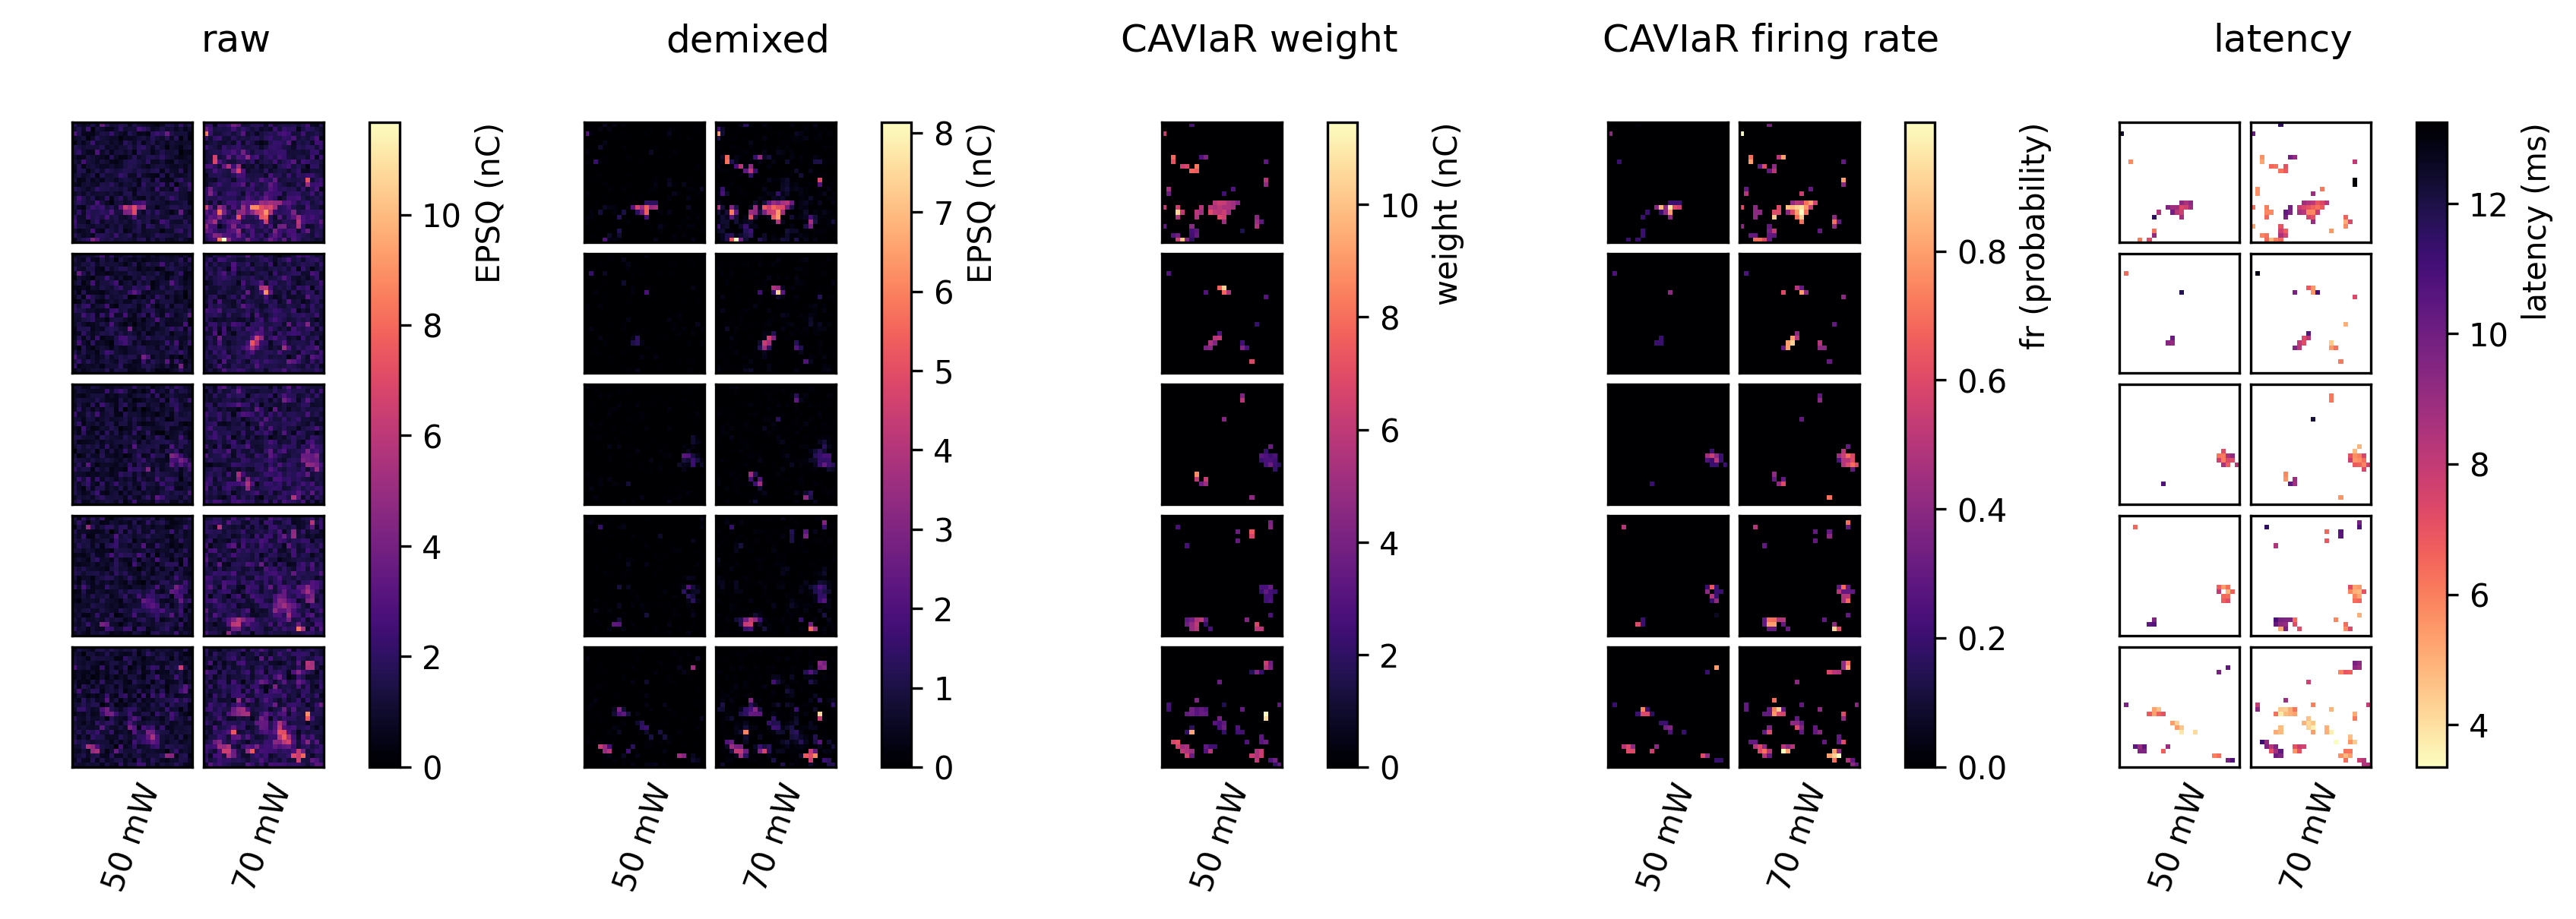

In [45]:
plot_kwargs = {'cmap':'magma'}
fig = plt.figure(figsize=(14, 0.75 * 5), dpi=300, facecolor='white')

# set zero to nan so that it's not shown in the latency plot
lat = grid_latencies
lat[lat == 0] = np.nan

# account for 5ms of context, since we've calculated latency from the start of each psc
lat = lat - 5.0

plot_multi_means(fig,
    [mean_raw, mean_demixed, mean_mbcs, rfs, lat], np.arange(5),
    map_names=['raw', 'demixed', 'CAVIaR weight', 'CAVIaR firing rate', 'latency'],
    cmaps=['magma', 'magma', 'magma', 'magma', 'magma_r'],
    cbar_labels=['EPSQ (nC)', 'EPSQ (nC)', 'weight (nC)', 'fr (probability)', 'latency (ms)'],
    powers=[50,70])
# plt.tight_layout()

Ttest_relResult(statistic=5.6798577369636245, pvalue=1.1100297198567786e-07)

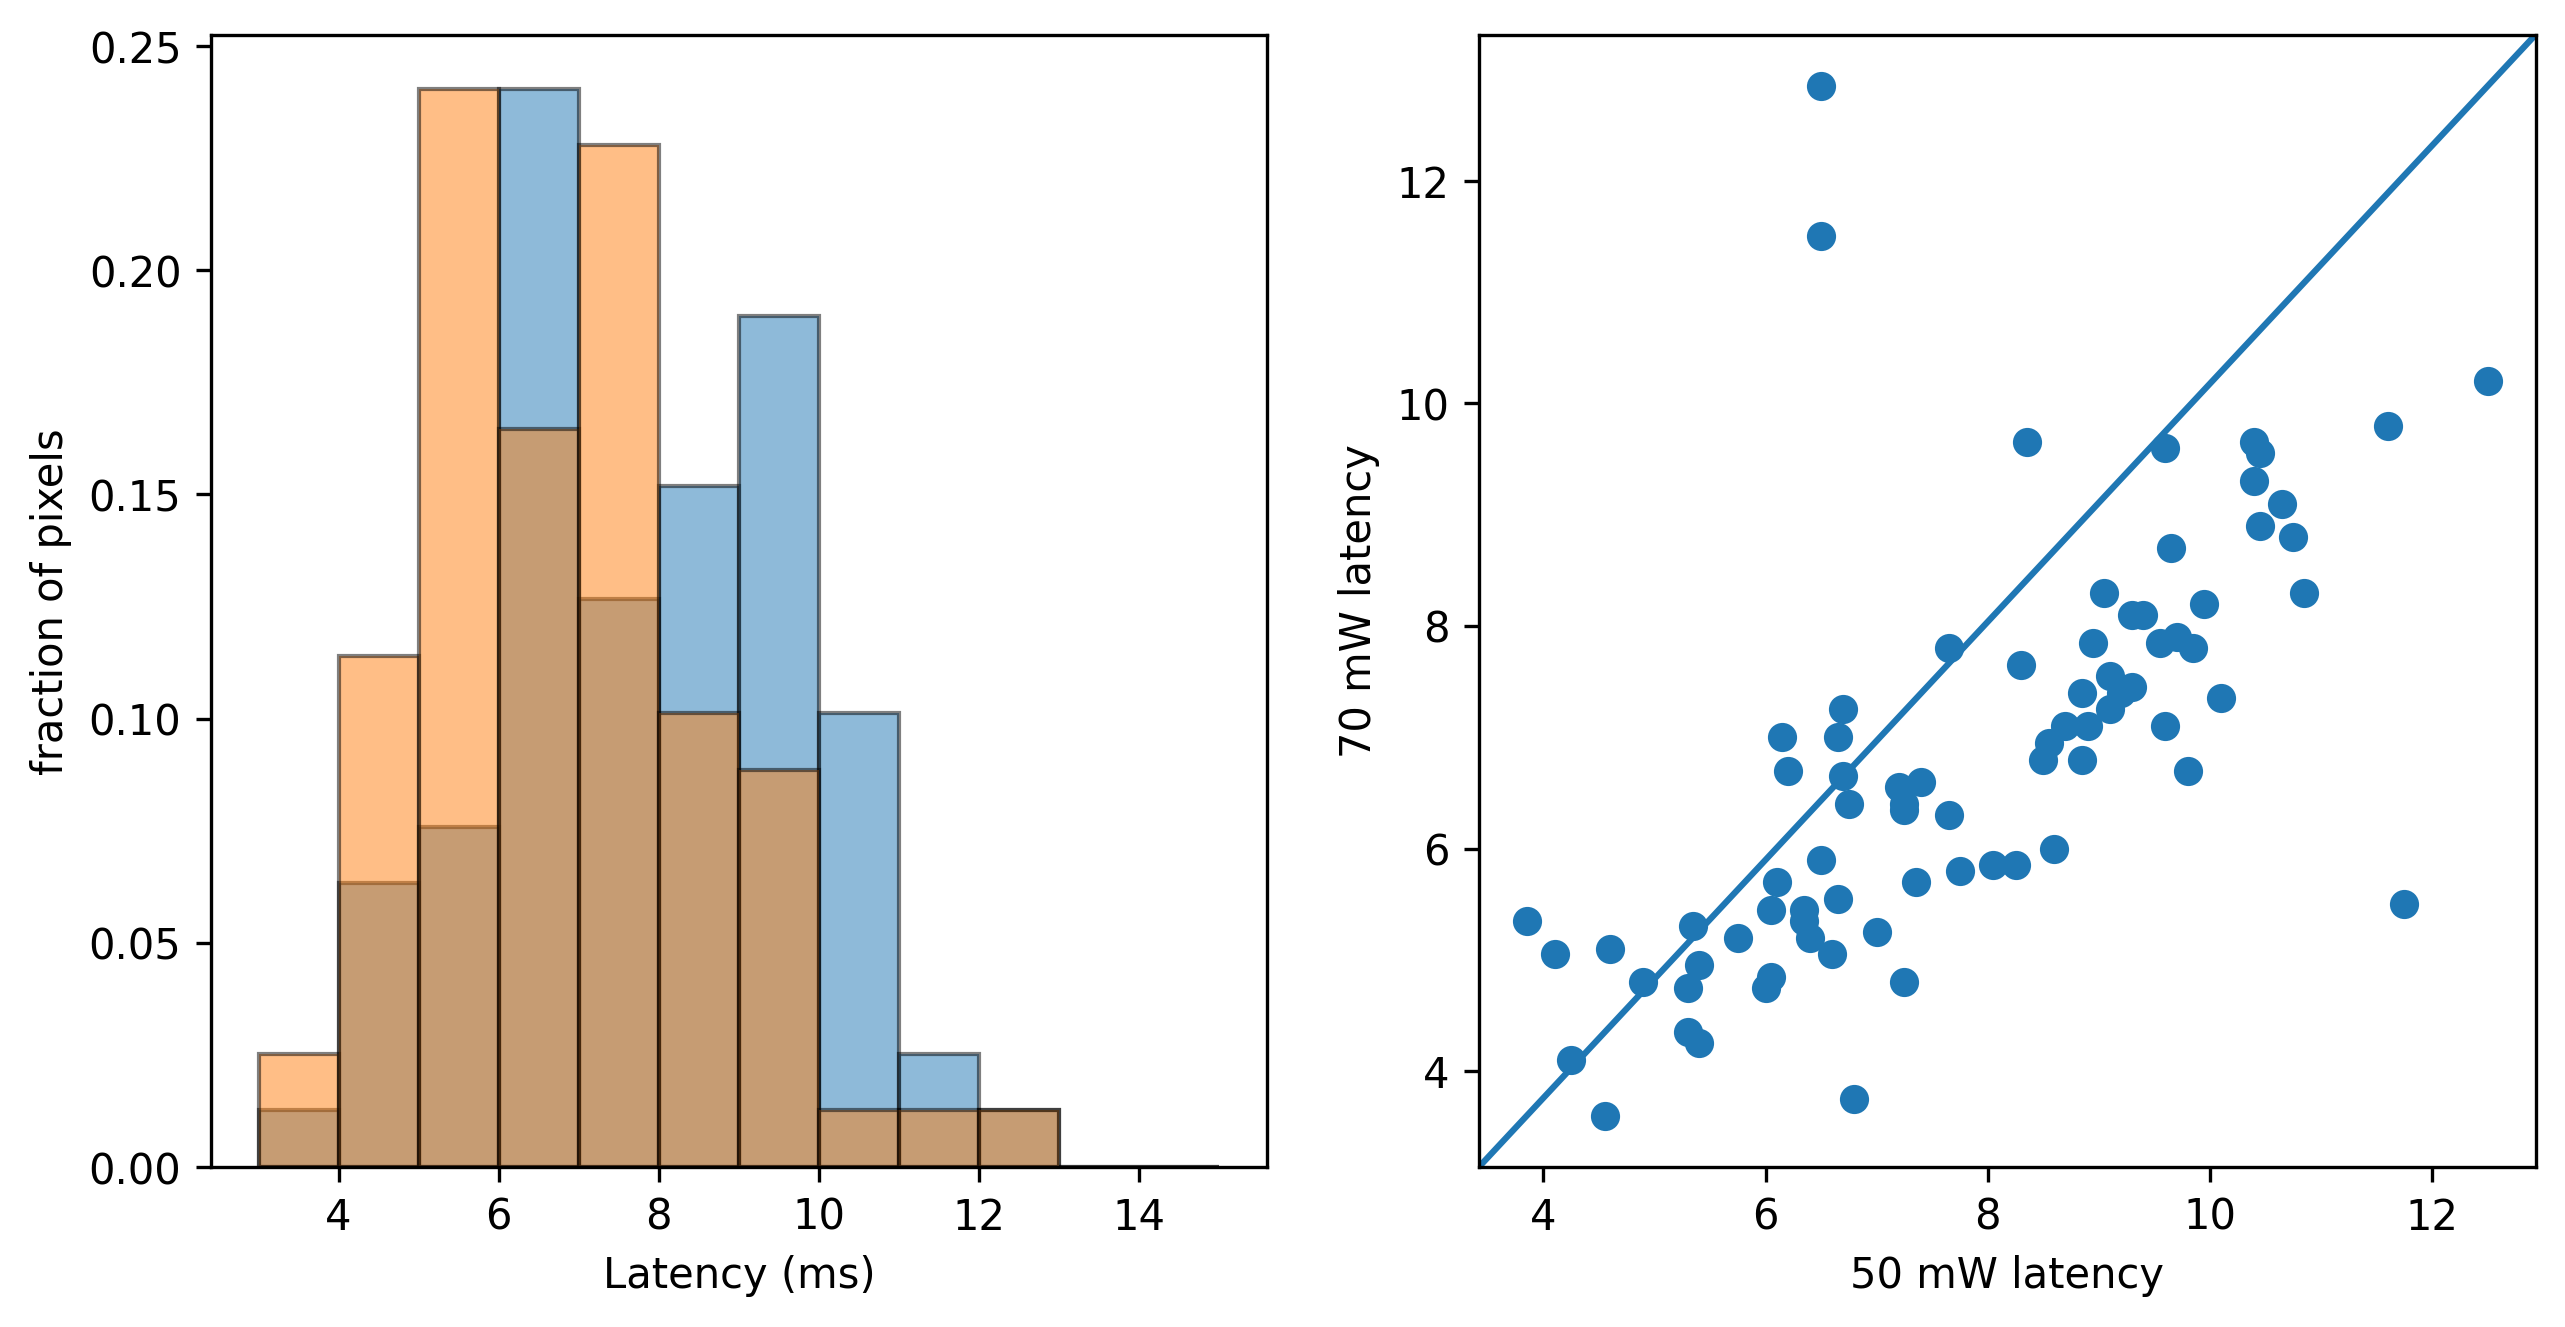

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=300, facecolor='white')

plt.sca(ax1)
bins = np.arange(3,16,step=1.0)

# get rid of nans in latencies for plotting
lat_low_power = lat[0].ravel()
lat_high_power = lat[-1].ravel()

idxs_to_keep = ~(np.isnan(lat_low_power) | np.isnan(lat_high_power))
lat_low_power = lat_low_power[idxs_to_keep]
lat_high_power = lat_high_power[idxs_to_keep]

plt.hist(lat_low_power, bins=bins, alpha=0.5, histtype='bar', ec='black', density=True)
plt.hist(lat_high_power, bins=bins, alpha=0.5, histtype='bar', ec='black', density=True)
plt.xlabel('Latency (ms)')
plt.ylabel('fraction of pixels')

plt.sca(ax2)
plt.scatter(lat[0].ravel(), lat[1].ravel())
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('50 mW latency')
plt.ylabel('70 mW latency')

ttest_rel(lat_low_power, lat_high_power, alternative='greater')

In [11]:
def plot_spike_inference_with_waveforms(den_psc, stim, I, model, waveforms, latencies,
                         spike_thresh=0.01, save=None, ymax=None, n_plots=15, num_trials=30, 
                         weights=None, col_width=10.5, row_height=0.6, order=None,
                         title=None, raw_psc=None):
    N = stim.shape[0]
    K = den_psc.shape[0]
    trial_len = 900
    normalisation_factor = np.max(np.abs(den_psc))
    trace_linewidth = 0.65
    ymax = 1.05
    ymin = -0.05 * ymax
    
    mu = model.state['mu']
    mu /= np.max(mu)
    lam = model.state['lam']
    z = model.state['z']

    fig = plt.figure(figsize=(col_width, row_height * n_plots * 1.5), dpi=300)
    
    # one columns for inferred waveforms
    powers = np.unique(I)
    width_ratios = np.zeros(len(powers) + 1)
    width_ratios[0:len(powers)] = 1
    width_ratios[-1] = n_plots
    gs = fig.add_gridspec(ncols=len(powers) + 1, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=width_ratios)
        
    for m in range(n_plots):
        n = order[m]
        
        # spike predictions
        ax = fig.add_subplot(gs[m,-1])
        
        if title is not None and m == 0:
            plt.title(title, fontsize=fontsize, y=1.5)
            
        
        trials_per_power = num_trials // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim[n] == pwr)[0][:trials_per_power]])
            
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_psc[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs), num_trials])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)
        
        if raw_psc is not None:
            this_y_psc_raw = raw_psc[stim_locs].flatten()/normalisation_factor

        plt.xlim([0, trial_len*n_repeats])
        
        # if we have ground truth weights
        if weights is None:
            trace_col = 'k'
        else:
            trace_col = 'k' if weights[n] != 0 else 'gray'
            
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam[n, stim_locs][tb] * mu[n], zorder=-5)
                           
            if z[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                
            # Plot power changes
            if (m == 0) and (I[stim_locs][tb] != I[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        if raw_psc is not None:
            plt.plot(this_y_psc_raw, color='gray', linewidth=trace_linewidth, alpha=0.5)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
#         plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)
        
    if waveforms is not None:
        ### Inferred PSC waveforms ###
        waveform_colors=['blue','green']
        for m in range(n_plots):
            n = order[m]
            

            for power_idx, power in enumerate(powers):
                ax = fig.add_subplot(gs[m,power_idx])
                
                plt.plot(waveforms[power_idx, n, :]/normalisation_factor,
                         color=waveform_colors[power_idx], linewidth=trace_linewidth)
                
                # draw vertical line at inferred latency, first convert to index
                sample_khz = 20
                samples_per_sec = sample_khz * 1e3
                secs_per_sample = 1 / samples_per_sec
                msecs_per_sample = secs_per_sample * 1e3
                plt.axvline(x=(latencies[power_idx, n] / msecs_per_sample),
                            color=waveform_colors[power_idx],
                            linewidth=trace_linewidth, linestyle='-.')

                for loc in ['top', 'right', 'left', 'bottom']:
                    plt.gca().spines[loc].set_visible(False)
                plt.xticks([])
                plt.yticks([])
                plt.ylim([ymin, ymax])

    plt.show()

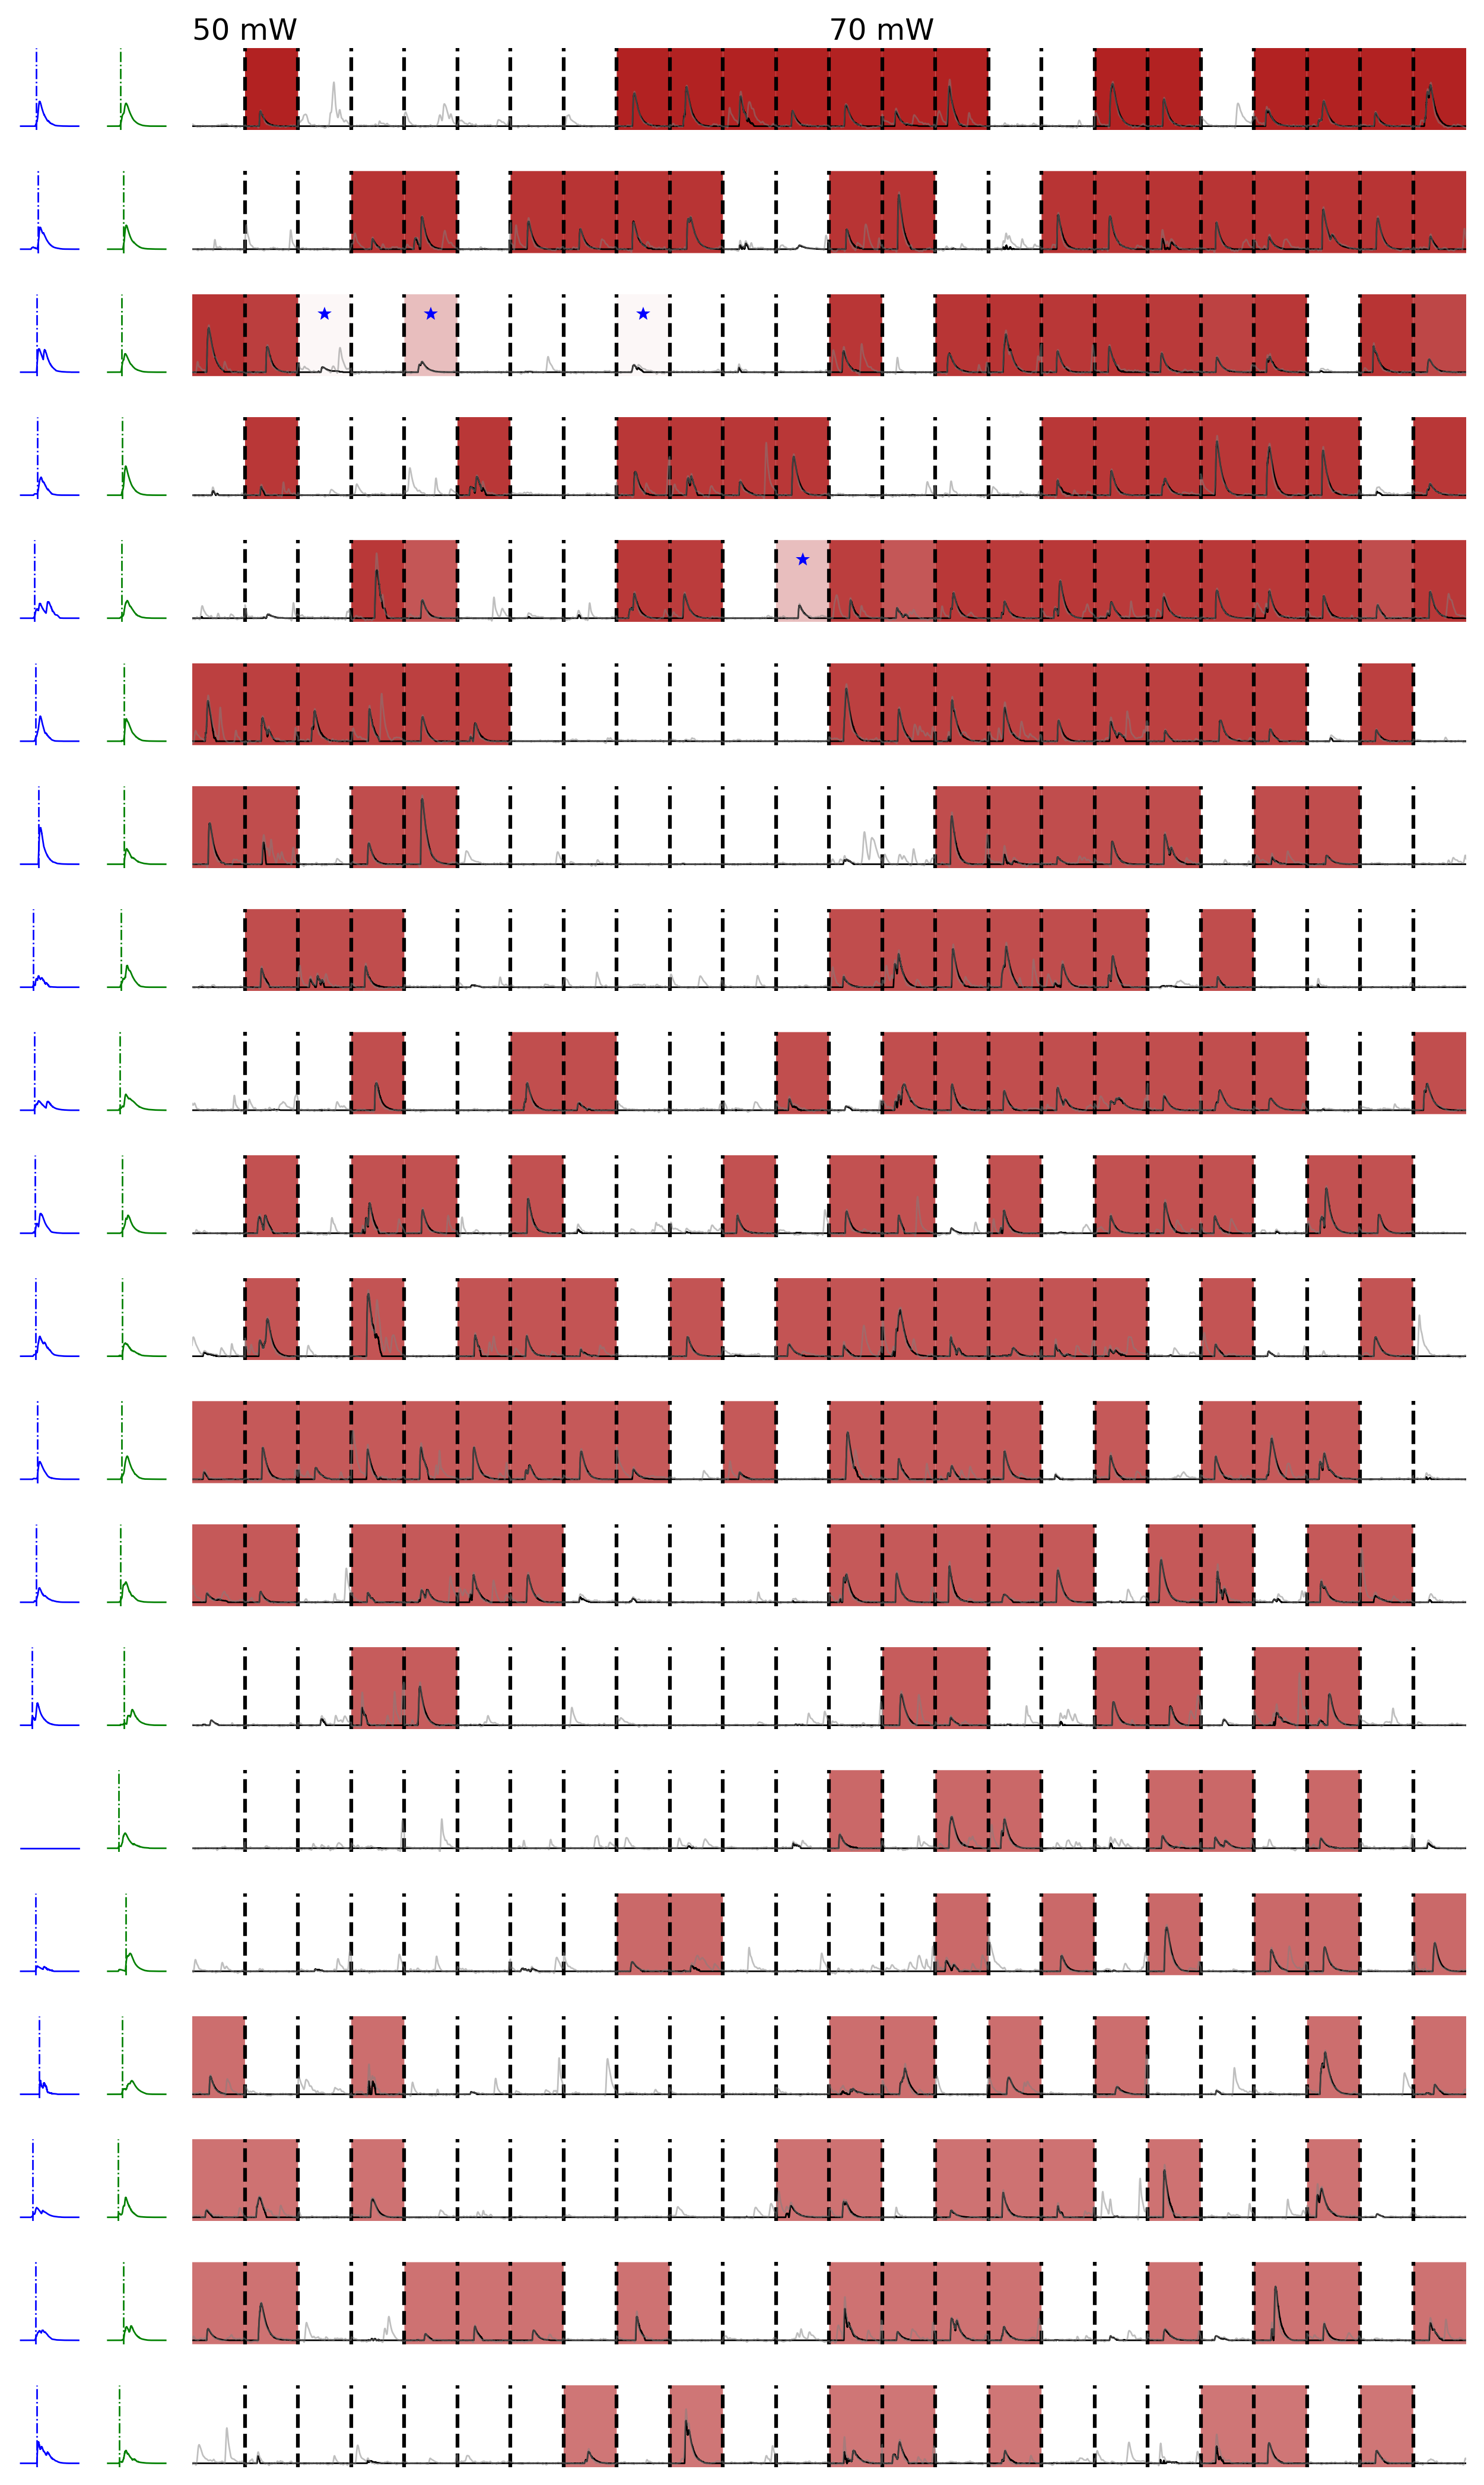

In [12]:
plane_to_plot = 0
den_psc = results['den_pscs'][plane_to_plot]
raw_psc = results['pscs'][plane_to_plot]
stim = results['stim_mats'][plane_to_plot]
I = results['Is'][plane_to_plot]
model = results['models'][plane_to_plot]
order = np.argsort(model.state['mu'])[::-1]
waveforms = np.swapaxes(wv[:,:,:,plane_to_plot,:], 1, 2).reshape(2,-1,900)
latencies = np.swapaxes(grid_latencies[:,:,:,plane_to_plot], 1, 2).reshape(2,-1)
fontsize=14

plot_spike_inference_with_waveforms(den_psc, stim, I, model, order=order, n_plots=20, raw_psc=raw_psc, waveforms=waveforms, latencies=latencies)

# jitter

- use extracted waveforms above, then find delay on each trial by getting the maximum value of the autocorrelation

In [11]:
from scipy import signal

def lag_finder(y1, y2, sr):
    n = len(y1)
#     import pdb; pdb.set_trace()
    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(
        signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])
    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    return delay * 1000 # convert to millisec

In [12]:
def make_grid_waveforms_all_powers(results, grid=None):
    if grid is None:
        grid = util.load_default_grid()
    
    # extract from results dict
    models = results['models']
    den_pscs = results['den_pscs']

    psc_length = den_pscs[0].shape[-1]
    grid_dims = grid.dims
    grid_waveforms = np.zeros((*grid_dims, psc_length)) # e.g 26, 26, 5, 900

    for plane_idx, model, den_psc in zip(range(len(models)), models, den_pscs):
        
        lam_curr = model.state['lam']
        
        curr_plane_waveforms = estimate_spike_waveforms(lam_curr, den_psc)
        curr_plane_waveforms = curr_plane_waveforms.reshape(grid_dims[0], grid_dims[1], psc_length)
        curr_plane_waveforms = np.swapaxes(curr_plane_waveforms, 0, 1)

        grid_waveforms[:,:,plane_idx,:] = curr_plane_waveforms
        
    return grid_waveforms

def get_jitter(waveforms, lam, den_psc):
    spike_times_flat = np.empty(waveforms.shape[0], dtype='object')
    for cell_idx, waveform in enumerate(waveforms):
        if np.sum(waveform) == 0.0: # skip disconnected cells
            continue 
        this_lam = lam[cell_idx, :]
        these_pscs = den_psc[this_lam > 0.5,:]

#         if these_pscs.shape[0] == 1:
#             import pdb; pdb.set_trace()
            
        # iterate over the trials where the cell spikes and calculate the lag
        if np.size(these_pscs) > 0:
            lags = np.zeros(these_pscs.shape[0])
            for psc_idx, psc in enumerate(these_pscs):
                
                # compute lag via autocorrelation
                lag = lag_finder(waveform, psc, sr=20000)
                lags[psc_idx] = lag

            spike_times_flat[cell_idx] = lags
    return np.vectorize(lambda x: np.std(x) if x is not None else np.nan)(spike_times_flat)

## test autocorrelation method

1. get all waveforms from the first plane, take the largest one
2. find a trial where that cell spiked
3. align using autocorrelation and plot result

In [16]:
wv_flat = np.reshape(wv, (-1, 900))
idx_max = np.argsort(wv_flat.s)

In [60]:
wv_all_powers = make_grid_waveforms_all_powers(results)
grid_jitter = np.zeros_like(mean_demixed)
powers = np.unique(results['Is'][0])

for plane_idx in range(5):
    waveforms = wv_all_powers[:, :, plane_idx, :].reshape(-1, 900)
    for power_idx, power in enumerate(powers):
        these_trials = results['Is'][plane_idx] == power
        
        lam = results['models'][plane_idx].state['lam']
        den_psc = results['den_pscs'][plane_idx]

        this_jitter = get_jitter(waveforms, lam[:, these_trials], den_psc[these_trials, :])
        grid_jitter[power_idx,:,:,plane_idx] = this_jitter.reshape(26, 26).T

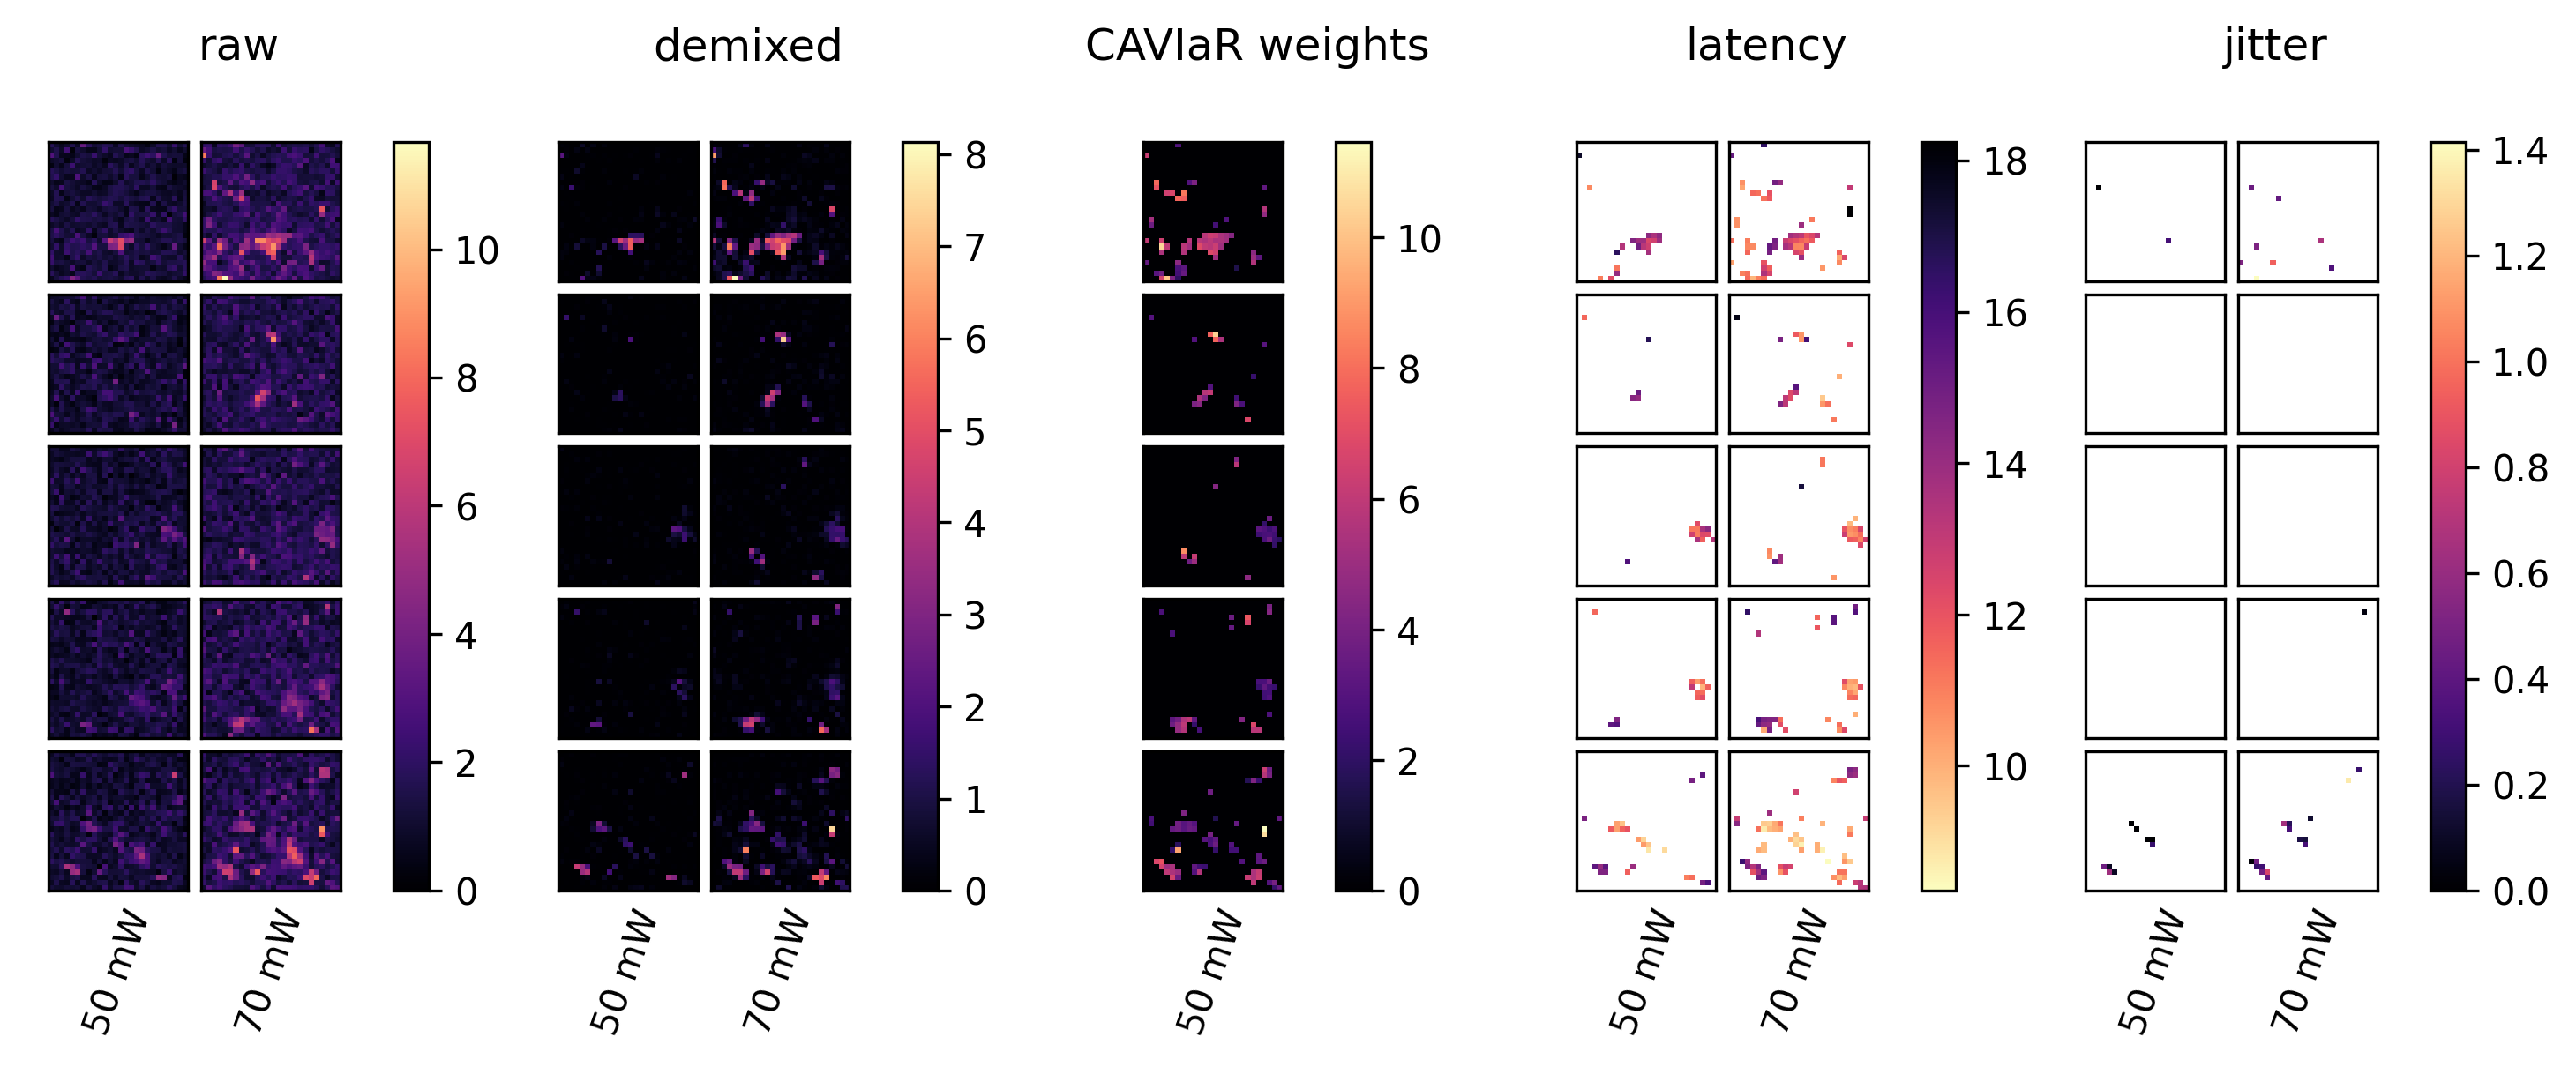

In [61]:
fig = plt.figure(figsize=(12, 0.75 * 5), dpi=300, facecolor='white')

plot_multi_means(fig,
    [mean_raw, mean_demixed, mean_mbcs, lat, grid_jitter], np.arange(5),
    map_names=['raw', 'demixed', 'CAVIaR weights', 'latency', 'jitter'],
    cmaps=['magma', 'magma', 'magma', 'magma_r', 'magma'],
    powers=[50,70])